<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/simulacoes_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulações para active learning:** 

*   Primeiramente iremos mostrar o exemplo utilizado por Settles na coletânea da literatura de active learning:

In [ ]:
# importando principais bibliotecas a serem utilizadas
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from scipy import stats

Geraremos um mistura de normais com certa interseção, mas com uma divisão clara:



In [ ]:
# 400 amostras, 200 para cada lado
seed = 975
np.random.seed(seed)
n_class = 200
classes = np.concatenate([np.zeros(n_class), np.ones(n_class)])
np.random.shuffle(classes)

In [ ]:
X = np.zeros((2*n_class, 3))
mu_0 = [-2, 0]
mu_1 = [2, 0]
cov = [[1, 0], [0, 1]] 
X[classes == 0, 0:2] = np.random.multivariate_normal(mu_0, cov, 200)
X[classes == 1, 0:2] = np.random.multivariate_normal(mu_1, cov, 200)
X[:, 2] = np.arange(0, 400)
# primeira mistura de duas normais mu_0 = [2, 0], mu_0 = [-2, 0]
# segunda eh uma normal mu_0 = [0, 0]

sim_data = pd.DataFrame(data = {'X1' : X[:, 0],
                                 'X2' : X[:, 1],
                                'index' : X[:, 2],
                                 'target':classes})

Em um gráfico 2D, teriamos a seguinte distribuição das classes:

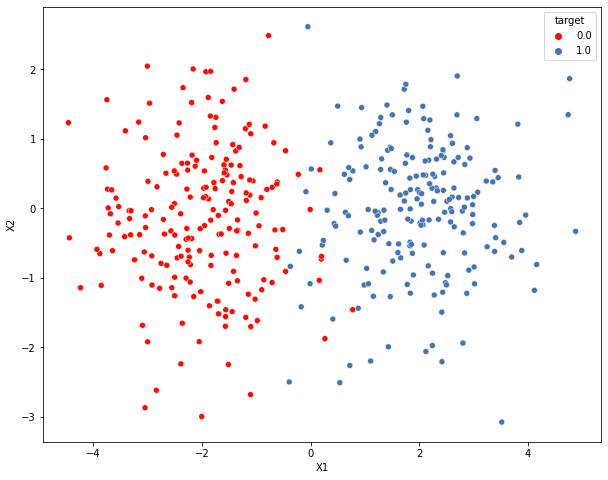

In [ ]:
colors = ["#FF0B04", "#4374B3", "black"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,8 ))
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'target')
plt.show()

Fazendo a imagem que mostra os pontos mais importantes através de uma regressão logística:

In [ ]:
!pip install modAL
from sklearn.linear_model import LogisticRegression
from modAL import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# fixando a semente
seed = 1600
np.random.seed(seed)

# setando as amostras iniciais:
# apenas 10 para treinamento
n_initial = 15
X_pool = np.copy(X)
y_pool = np.copy(classes)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

logis = LogisticRegression(penalty = 'none')

learner_logis = ActiveLearner(
    estimator = logis,
    query_strategy = uncertainty_sampling
)


learner_logis.teach(X_train[:, 0:2], y_train)

In [ ]:
y_train

array([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.])

In [ ]:
sim_data['new_classes'] = sim_data.loc[:, 'target']

In [ ]:
n_queries = 30
index_list = []
for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_logis, query_instance_logis = learner_logis.query(X_pool[:, 0:2])
  X_sel, y_sel = X_pool[query_index_logis, 0:2].reshape(1, -1), y_pool[query_index_logis].reshape(1, )
  learner_logis.teach(X = X_sel, y = y_sel)
  index_list.append(int(X_pool[query_index_logis, 2]))
  X_pool, y_pool = np.delete(X_pool, query_index_logis, axis=0), np.delete(y_pool, query_index_logis)


In [ ]:
sim_data.loc[~sim_data.index.isin(index_list), 'new_classes'] = np.repeat('não selecionado', 370)

In [ ]:
w1, w2 = learner_logis.estimator.coef_.T
b = learner_logis.estimator.intercept_
# calculando o intercepto e gradiente da fronteira
c = -b/w2
m = -w1/w2

Plotando lado a lado para comparação:

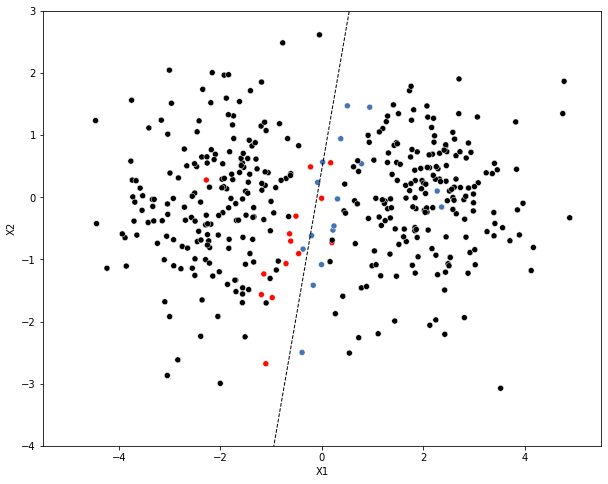

In [ ]:
colors = ["#4374B3", "#FF0B04", "black"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,8 ))
xmin, xmax = -5, 5
ymin, ymax = -4, 3
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')

sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'new_classes', legend = False)
plt.ylim(-4, 3)
plt.show()

Fazendo ambos os graficos lado a lado:

Mounted at /content/gdrive


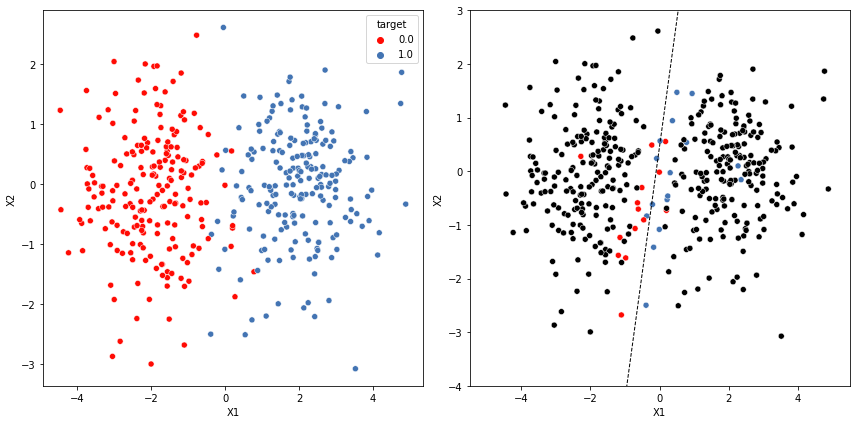

In [ ]:
# chamando o drive para salvar as imagens
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'

fig, axes = plt.subplots(1, 2, figsize = (12, 6))
plt.subplot(1,2,1)
colors = ["#FF0B04", "#4374B3", "black"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'target')
plt.subplot(1,2,2)
colors = ["#4374B3", "#FF0B04", "black"]
sns.set_palette(sns.color_palette(colors))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'new_classes', legend = False)
plt.ylim(-4, 3)

plt.tight_layout()
plt.savefig(f"{images_dir}/uncertainty_toy_example.pdf")

In [ ]:
learner_logis.score(X[:, 0:2], classes)

0.9725

In [ ]:
!pip install modAL
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from modAL import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

rf = RandomForestClassifier(n_estimators = 150)
logis = LogisticRegression(penalty = 'none')

# declarando o learner para o random forest
learner_rf = ActiveLearner(
    estimator = rf,
    query_strategy = uncertainty_sampling
)

# declarando o learner para o logistica
learner_logis = ActiveLearner(
    estimator = logis,
    query_strategy = uncertainty_sampling
)


from sklearn.model_selection import train_test_split
X_train_total, X_test, y_train_total, y_test = train_test_split(X, classes, test_size = 0.2, random_state = 120, stratify = classes)
# fixando a semente
seed = 1050
np.random.seed(seed)

# setando as amostras iniciais:
# 5 para treinamento inicial
n_initial = 5
X_pool = np.copy(X_train_total)
y_pool = np.copy(y_train_total)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# tomando uma pool para RF e outra para logistica
X_pool_rf, X_pool_random_rf = np.copy(X_pool), np.copy(X_pool)
y_pool_rf, y_pool_random_rf = np.copy(y_pool), np.copy(y_pool)

X_pool_logis, X_pool_random_logis = np.copy(X_pool), np.copy(X_pool)
y_pool_logis, y_pool_random_logis = np.copy(y_pool), np.copy(y_pool)

learner_rf.teach(X_train, y_train)
learner_logis.teach(X_train, y_train)

In [ ]:
n_queries = 100
unqueried_score_rf = learner_rf.score(X_test, y_test)
unqueried_score_random= learner_logis.score(X_test, y_test)
performance_history_rf = [unqueried_score_rf]
performance_history_rf_random = [unqueried_score_rf]
performance_history_logis = [unqueried_score_random]
performance_history_logis_random = [unqueried_score_random]
from sklearn.base import clone


learner_rf_random, learner_logis_random = clone(learner_rf), clone(learner_logis)
for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_rf, query_instance_rf = learner_rf.query(X_pool_rf)
  query_index_logis, query_instance_logis = learner_logis.query(X_pool_logis)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_rf[query_index_rf].reshape(1, -1), y_pool_rf[query_index_rf].reshape(1, )
  learner_rf.teach(X = X_sel, y = y_sel)
  X_pool_rf, y_pool_rf = np.delete(X_pool_rf, query_index_rf, axis=0), np.delete(y_pool_rf, query_index_rf)
  
  # logistica
  X_sel, y_sel = X_pool_logis[query_index_logis].reshape(1, -1), y_pool_logis[query_index_logis].reshape(1, )
  learner_logis.teach(X = X_sel, y = y_sel)
  X_pool_logis, y_pool_logis = np.delete(X_pool_logis, query_index_logis, axis=0), np.delete(y_pool_logis, query_index_logis)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf.score(X_test, y_test)
  model_accuracy_logis = learner_logis.score(X_test, y_test)
  
  # historico de performance para ambos
  performance_history_rf.append(model_accuracy_rf)
  performance_history_logis.append(model_accuracy_logis)

  # amostra aleatoria dos indices
  sample_idx_rf = np.random.choice(range(len(X_pool_random_rf)), size = 1, replace = False)
  sample_idx_logis = np.random.choice(range(len(X_pool_random_logis)), size = 1, replace = False)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_random_rf[sample_idx_rf].reshape(1, -1), y_pool_rf[sample_idx_rf].reshape(1, )
  learner_rf_random.teach(X = X_sel, y = y_sel)
  X_pool_random_rf, y_pool_random_rf = np.delete(X_pool_random_rf, sample_idx_rf, axis=0), np.delete(y_pool_random_rf, sample_idx_rf)
  
  # logistica
  X_sel, y_sel = X_pool_random_logis[sample_idx_logis].reshape(1, -1), y_pool_random_logis[sample_idx_logis].reshape(1, )
  learner_logis_random.teach(X = X_sel, y = y_sel)
  X_pool_random_logis, y_pool_random_logis = np.delete(X_pool_random_logis, sample_idx_logis, axis=0), np.delete(y_pool_random_logis, sample_idx_logis)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf_random.score(X_test, y_test)
  model_accuracy_logis = learner_logis_random.score(X_test, y_test)
  
  # historico de performance para ambos
  performance_history_rf_random.append(model_accuracy_rf)
  performance_history_logis_random.append(model_accuracy_logis)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


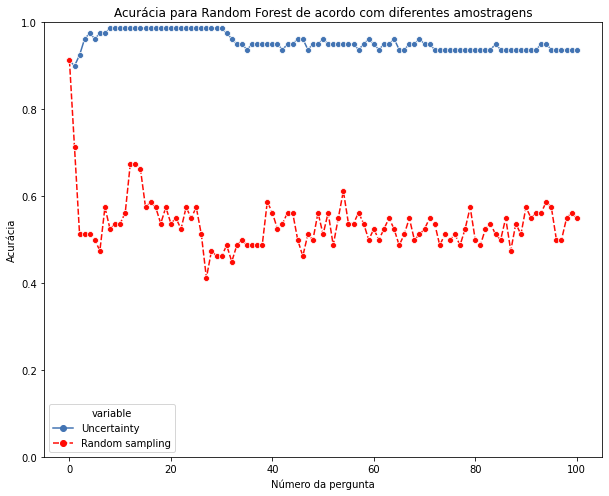

In [ ]:
plt.figure(figsize = (10, 8))

rf_data = pd.DataFrame(data = {'Uncertainty': performance_history_rf,
                               'Random sampling': performance_history_rf_random,
                            'Query': np.arange(0,101)})

melt_data = pd.melt(rf_data, id_vars = ['Query'], value_vars = ['Uncertainty', 'Random sampling'])

sns.lineplot(data = melt_data, x = "Query", y = "value", markers=["o", "o"], hue = "variable", style="variable") 
plt.title("Acurácia para Random Forest de acordo com diferentes amostragens")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

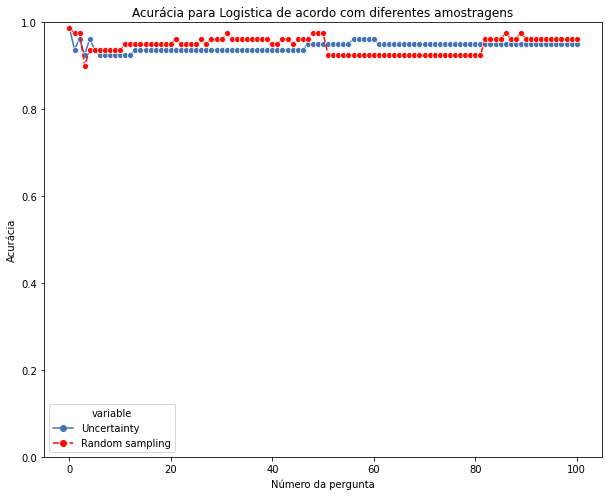

In [ ]:
plt.figure(figsize = (10, 8))

rf_data = pd.DataFrame(data = {'Uncertainty': performance_history_logis,
                               'Random sampling': performance_history_logis_random,
                            'Query': np.arange(0,101)})

melt_data = pd.melt(rf_data, id_vars = ['Query'], value_vars = ['Uncertainty', 'Random sampling'])

sns.lineplot(data = melt_data, x = "Query", y = "value", markers=["o", "o"], hue = "variable", style="variable") 
plt.title("Acurácia para Logistica de acordo com diferentes amostragens")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

# Obtendo gráficos de simulações para exemplos na metodologia do TG:

Averiguando como se comporta cada medida para uma classificação ternária:

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


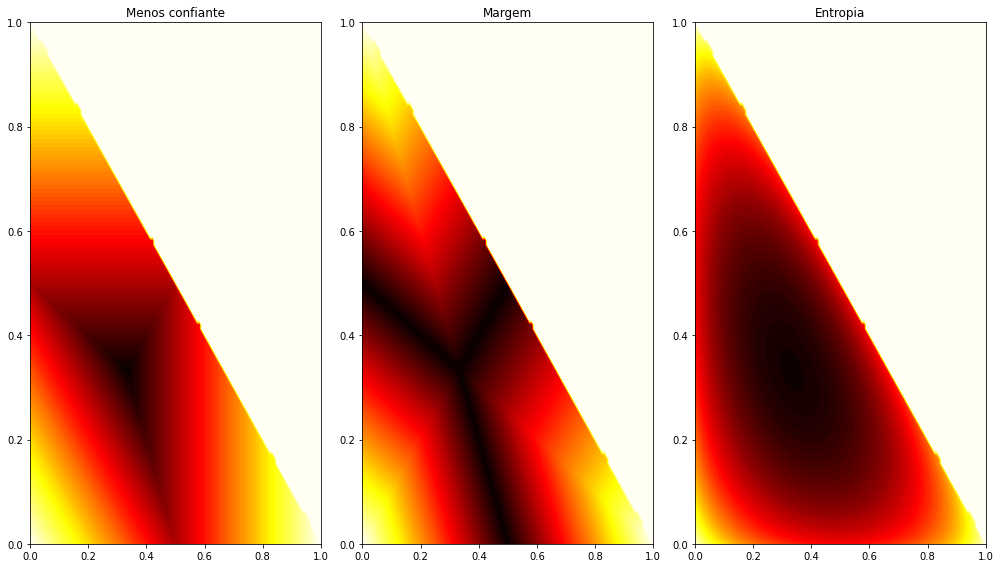

In [ ]:
from itertools import product
from matplotlib import colors
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'


n_res = 125
plt.style.context('seaborn-white')
fig, axes = plt.subplots(1, 3, figsize = (14, 8))
p1, p2 = np.meshgrid(np.linspace(0, 1, n_res), np.linspace(0, 1, n_res))
p3 = np.maximum(1 - p1 - p2, 0)

uncertainty_less_conf = 1 - np.maximum.reduce([p1, p2, p3])

proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T
part = np.partition(-proba, 1, axis=1)

margin = - part[:, 0] + part[:, 1]
margin = margin.reshape(p1.shape)

from scipy.stats import entropy
entr = entropy(proba.T).reshape(p1.shape)

plt.subplot(1,3,1)
mapColS = [plt.cm.hot(i) for i in np.linspace(0.99, 0, 250)]
MyCmap = colors.ListedColormap(mapColS)
plt.contourf(p1, p2, uncertainty_less_conf*((p1+p2) < 1), 100, cmap = MyCmap)
plt.title('Menos confiante')

plt.subplot(1,3,2)
plt.contourf(p1, p2, (1-margin)*((p1+p2) < 1), 100, cmap = MyCmap)
plt.title('Margem')

plt.subplot(1,3,3)
plt.contourf(p1, p2,  entr*((p1+p2) < 1), 100, cmap = MyCmap)
plt.title('Entropia')

plt.tight_layout()
plt.savefig(f"{images_dir}/metodos_em_ternarios.pdf")

Simulando um problema de active regression semelhante ao de modAL:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

n = 250
np.random.seed(500)
X = np.random.choice(np.linspace(0, 20, 10000), size = n, replace=False).reshape(-1, 1)
index = np.arange(250)
y = 1.5*np.cos(X) - 1.5*np.sin(X) + np.random.normal(scale= 0.45, size=X.shape)

In [ ]:
# utilizando agora o processo gaussiano
# definindo a medida de incerteza personalizada antes
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

# treinando o processo gaussiano com uma amostra inicial
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_pool, y_pool = np.copy(X), np.copy(y)
X_training, y_training = X_pool[initial_idx], y_pool[initial_idx]

s = []
col = []
for i in range(0, n):
  if i in initial_idx:
    col.append('red')
    s.append(50)
  else:
    col.append('black')
    s.append(20)
col2 = col.copy()
s2 = s.copy()
X_grid = np.linspace(0, 20, 10000).reshape(-1, 1)
index = np.delete(index, initial_idx)
# reduzindo a pool
X_pool = np.delete(X_pool, initial_idx, axis=0)
y_pool = np.delete(y_pool, initial_idx, axis = 0)

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(),
    query_strategy = GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

# predicoes iniciais
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

# active learning
n_queries = 15
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X_pool)
    regressor.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1, -1))
    col2[index[query_idx]] = 'green'
    s2[index[query_idx]] = 50
    index = np.delete(index, query_idx)
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

# predicoes finais
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


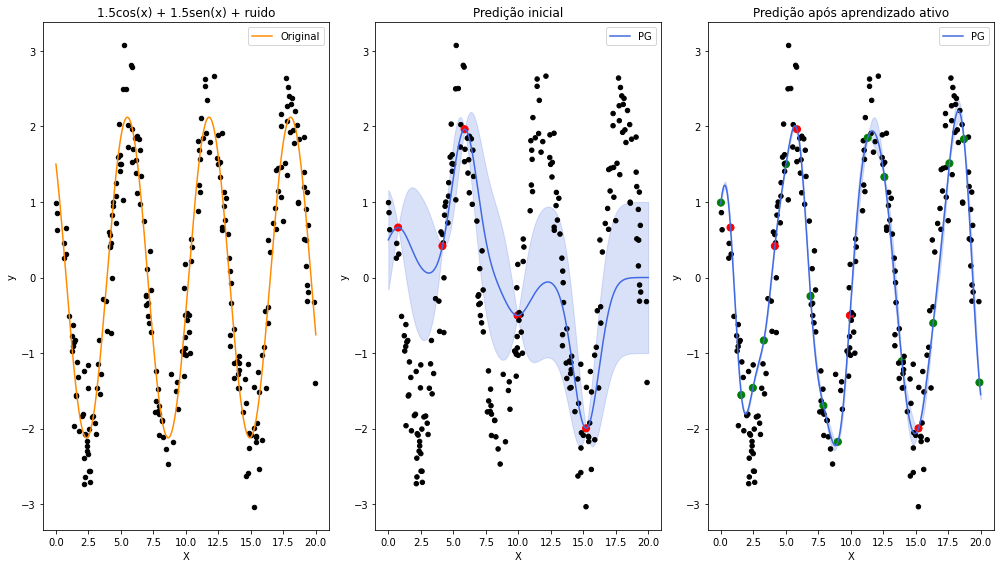

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'

plt.style.context('seaborn-white')
fig, axes = plt.subplots(1, 3, figsize = (14, 8))

plt.subplot(1,3,1)
plt.scatter(X, y, c='k', s=20)
X_grid = np.linspace(0, 20, 10000)
plt.plot(X_grid, 1.5*np.cos(X_grid) - 1.5*np.sin(X_grid), label = "Original", color = "darkorange")
plt.title("1.5cos(x) + 1.5sen(x) + ruido")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")


plt.subplot(1,3,2)
plt.plot(X_grid, y_pred, label = "PG", color = "royalblue")
plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2, color = "royalblue")
plt.scatter(X, y, c = col, s = s)
plt.title('Predição inicial')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

plt.subplot(1,3,3)
plt.plot(X_grid, y_pred_final, label = "PG", color = "royalblue")
plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2, color = "royalblue")
plt.scatter(X, y, c= col2, s = s2)
plt.title('Predição após aprendizado ativo')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.savefig(f"{images_dir}/processo_gaussiano_active_regression.pdf")

Plotando os gráficos de pizza para diferentes P:

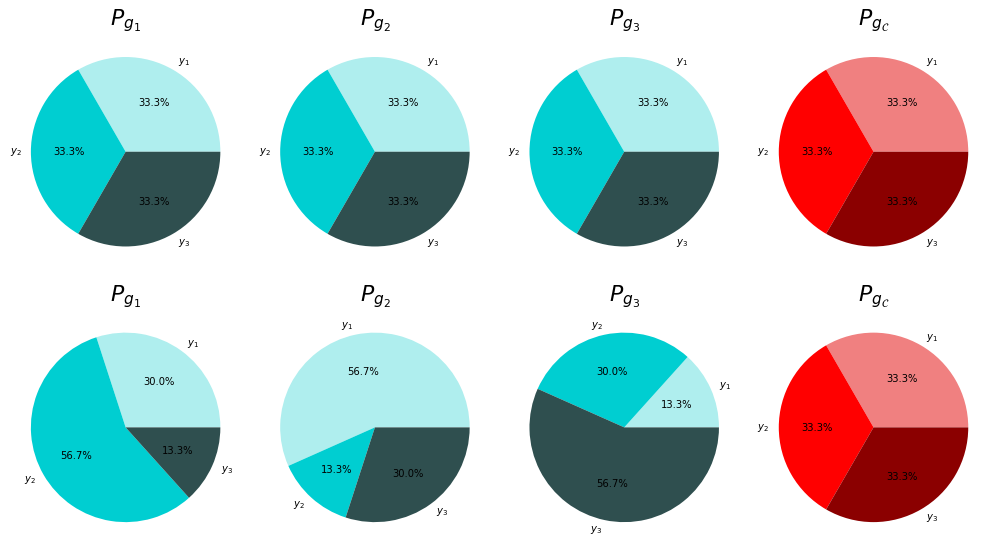

In [ ]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
colors = ['paleturquoise','darkturquoise', 'darkslategray']
colors2 = ['lightcoral', 'red', 'darkred']
labels = [r'$y_1$', r'$y_2$', r'$y_3$']
fig, axes = plt.subplots(2, 4, figsize = (14, 8))
p_s = np.array([[0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
                [0.45, 0.85, 0.2],
                [0.85, 0.2, 0.45],
                [0.2, 0.45, 0.85],
                [0.5, 0.5, 0.5]])
lista = ['$P_{g_{1}}$', '$P_{g_{2}}$', '$P_{g_{3}}$', '$P_{g_{\mathcal{C}}}$',
         '$P_{g_{1}}$', '$P_{g_{2}}$', '$P_{g_{3}}$', '$P_{g_{\mathcal{C}}}$']
for i, ax in enumerate(axes.flatten()):
  if i not in [3, 7]:
    ax.pie(p_s[i, ], colors = colors, labels=labels, 
        autopct='%1.1f%%')
    ax.set_title(r'{}'.format(lista[i]), fontsize = 22)
  else:
    ax.pie(p_s[i, ], colors = colors2, labels=labels, 
        autopct='%1.1f%%')
    ax.set_title(r'{}'.format(lista[i]), fontsize = 22)

plt.tight_layout()
plt.savefig(f"{images_dir}/proportions_committee.pdf")

Fazendo outro exemplo do livro utilizando regressão logística multinomial e regressão logística com bagging:

In [ ]:
# gerando dados com 3 labels:
# poucos dados sem muita interseção
n_1, n_2 = 3, 3
n_3 = 4

seed = 950
np.random.seed(seed)
classes = np.concatenate([np.zeros(n_1), np.ones(n_2), np.repeat(2, n_3)])
classes

array([0., 0., 0., 1., 1., 1., 2., 2., 2., 2.])

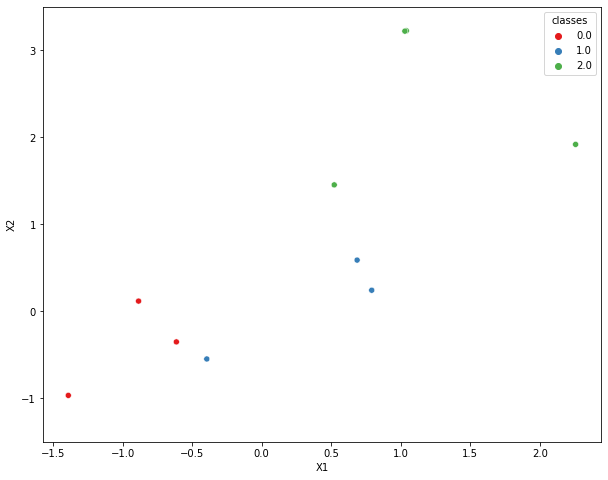

In [ ]:
# dados do treinamento do modelo de aprendizado ativo
X = np.zeros((n_1 + n_2 + n_3, 2))
mu_0 = [-0.75, 0]
mu_1 = [1, 0]
mu_2 = [1, 2]
cov = [[0.5, 0], [0, 0.5]] 
X[classes == 0, :] = np.random.multivariate_normal(mu_0, cov, n_1)
X[classes == 1, :] = np.random.multivariate_normal(mu_1, cov, n_2)
X[classes == 2, :] = np.random.multivariate_normal(mu_2, cov, n_3)
# primeira mistura de duas normais mu_0 = [2, 0], mu_0 = [-2, 0]
# segunda eh uma normal mu_0 = [0, 0]

sim_data = pd.DataFrame(data = {'X1' : X[:, 0],
                                 'X2' : X[:, 1],
                                 'target': classes})

sns.set_palette("Set1")
plt.figure(figsize = (10,8 ))
sim_data['classes'] = pd.Categorical(sim_data.target)
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'classes')
plt.ylim(-1.5, 3.5)
plt.show()

In [ ]:
print(X[classes == 2, :])
print(X[classes == 1, :])

[[0.52211107 1.45409798]
 [1.04072577 3.22574702]
 [2.25787881 1.91953198]
 [1.03000159 3.22152662]]
[[ 0.79141227  0.24265792]
 [ 0.68667706  0.58922792]
 [-0.39460184 -0.54766706]]


Criando agora um único classificador multinomial de regressão, com esses dados de treinamento para realizar aprendizado ativo com amostragem por incerteza:

In [ ]:
# classificador
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import classifier_entropy

learner_logis = ActiveLearner(
    estimator = LogisticRegression(penalty = 'none'),
    query_strategy = entropy_sampling
)


learner_logis.teach(X, classes)

Visualizando como se comporta a entropia em um mapa de calor:

In [ ]:
# fazendo o modelo logistico com bagging e testando a entropia de voto e KL
# inicializando os 10 learners logisticos
n_learners = 10
learner_list = []

seed = 950
np.random.seed(seed)

for _ in range(n_learners):
  learner = ActiveLearner(
      estimator = LogisticRegression(penalty = 'none'),
      X_training = X, y_training = classes,
      bootstrap_init=True)
  learner_list.append(learner)


# juntando os learners no comite
from modAL.models import Committee
comite_logis = Committee(learner_list)

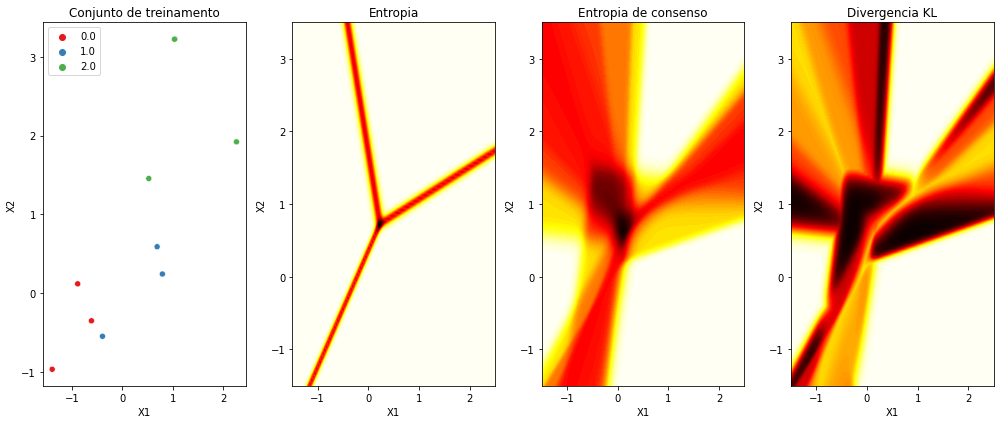

In [ ]:
from matplotlib import colors
from modAL.disagreement import consensus_entropy, KL_max_disagreement
from modAL.uncertainty import classifier_entropy

sns.set_palette("Set1")
fig, axes = plt.subplots(1, 4, figsize = (14, 6))
# fazendo a grid
n_res = 125
x1, x2 = np.meshgrid(np.linspace(-1.5, 2.5, n_res), np.linspace(-1.5, 3.5, n_res))
z = np.stack((x1.ravel(), x2.ravel()), axis=-1)
# cor do mapa de calor
mapColS = [plt.cm.hot(i) for i in np.linspace(0.99, 0, 250)]
MyCmap = colors.ListedColormap(mapColS)

# grafico feito
plt.subplot(1,4,1)
sim_data['classes'] = pd.Categorical(sim_data.target)
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'classes')
plt.legend(loc='upper left')
plt.title('Conjunto de treinamento')

plt.subplot(1, 4, 2)
plt.contourf(x1, x2, np.reshape(classifier_entropy(learner_logis, z), (125, 125)), 100, cmap = MyCmap)
plt.title('Entropia')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1, 4, 3)
plt.contourf(x1, x2, np.reshape(consensus_entropy(comite_logis, z), (125, 125)), 100, cmap = MyCmap)
plt.title('Entropia de consenso')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1, 4, 4)
plt.contourf(x1, x2, np.reshape(KL_max_disagreement(comite_logis, z), (125, 125)), 100, cmap = MyCmap)
plt.title('Divergencia KL')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.savefig(f"{images_dir}/comparacoes_heuristicas_comite.pdf")

Simulando dados para a regressão ativa por comitê:

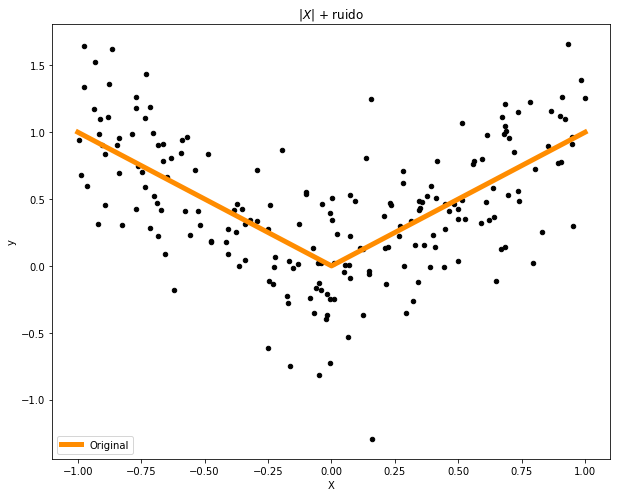

In [ ]:
from modAL.disagreement import max_std_sampling
from modAL.models import CommitteeRegressor

n = 200
seed = 1050
np.random.seed(seed)
index = np.arange(n)

# generating the data
X = np.concatenate((np.random.rand(100)-1, np.random.rand(100)))
y = abs(X) + np.random.normal(scale=0.35, size=X.shape)

# inicializando 
n_initial = 10

initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_pool, y_pool = np.copy(X), np.copy(y)
X_train, y_train = X_pool[initial_idx], y_pool[initial_idx]

s = []
col = []
for i in range(0, n):
  if i in initial_idx:
    col.append('red')
    s.append(50)
  else:
    col.append('black')
    s.append(20)
col2 = col.copy()
s2 = s.copy()

index = np.delete(index, initial_idx)
# reduzindo a pool
X_pool = np.delete(X_pool, initial_idx, axis=0)
y_pool = np.delete(y_pool, initial_idx, axis = 0)

seed = 950
np.random.seed(seed)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
learner_list = []
n_learners = 3

for _ in range(n_learners):
  learner = ActiveLearner(
      estimator = GaussianProcessRegressor(kernel),
      X_training = X_train.reshape(-1, 1), y_training = y_train,
      bootstrap_init=True)
  learner_list.append(learner)

# juntando os learners no comite
comite_tree_bag = CommitteeRegressor(learner_list = learner_list,
                         query_strategy = max_std_sampling)

plt.figure(figsize=(10, 8))
plt.scatter(X, y, c='k', s=20)
X_grid = np.linspace(-1, 1, 10000)
plt.plot(X_grid, abs(X_grid), label = "Original", color = "darkorange", linewidth=5)
plt.title(r"$|X|$ + ruido")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.savefig(f"{images_dir}/dados_sim_reg_ativa.pdf")

Juntando todos os gráficos:

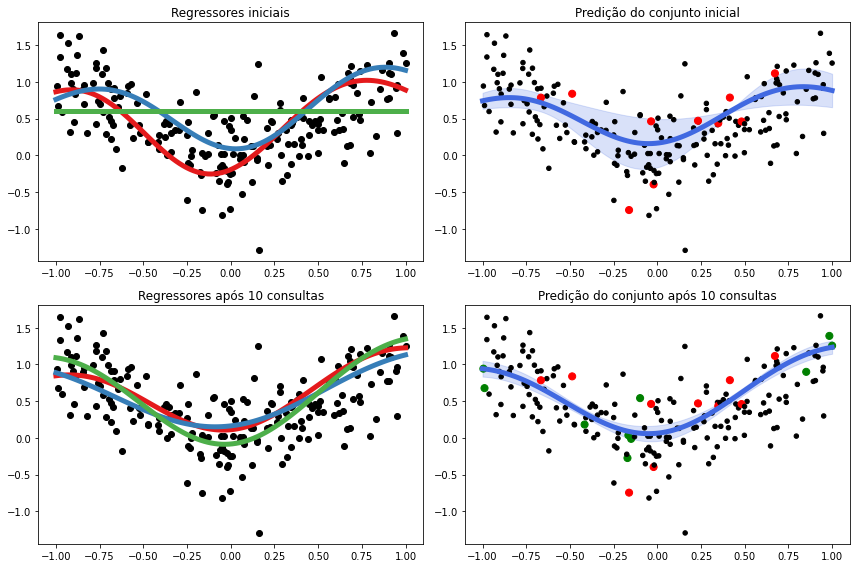

In [ ]:
plt.style.context('seaborn-white')

plt.figure(figsize=(12, 8))
x = np.linspace(-1, 1, 100)

plt.subplot(2, 2, 1)
for learner_idx, learner in enumerate(comite_tree_bag):
  plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
plt.scatter(X, y, c='k')
plt.title('Regressores iniciais')

plt.subplot(2, 2, 2)
pred, std = comite_tree_bag.predict(x.reshape(-1, 1), return_std=True)
pred = pred.reshape(-1, )
std = std.reshape(-1, )
plt.plot(x, pred, color = "royalblue", linewidth=5)
plt.fill_between(x, pred - std, pred + std, alpha=0.2, color = "royalblue")
plt.scatter(X, y, c = col, s = s)
plt.title('Predição do conjunto inicial')

# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = comite_tree_bag.query(X_pool.reshape(-1, 1))
    comite_tree_bag.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1,))
    col2[index[int(query_idx)]] = 'green'
    s2[index[int(query_idx)]] = 50
    comite_tree_bag.rebag()
    index = np.delete(index, query_idx)
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

# predicoes finais
y_pred_final, y_std_final = comite_tree_bag.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

plt.subplot(2, 2, 3)
for learner_idx, learner in enumerate(comite_tree_bag):
  plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
plt.scatter(X, y, c='k')
plt.title('Regressores após 10 consultas')

plt.subplot(2, 2, 4)
pred, std = comite_tree_bag.predict(x.reshape(-1, 1), return_std=True)
pred = pred.reshape(-1, )
std = std.reshape(-1, )
plt.plot(x, pred, color = "royalblue", linewidth=5)
plt.fill_between(x, pred - std, pred + std, alpha=0.2, color = "royalblue")
plt.scatter(X, y, c = col2, s = s2)
plt.title('Predição do conjunto após 10 consultas')

plt.tight_layout()
plt.savefig(f"{images_dir}/regressao_ativa_PG_comite.pdf")

Alguns gráficos para densidade de informação: Ilustrando primeiramente a presença de pontos sem importância e pontos importantes:

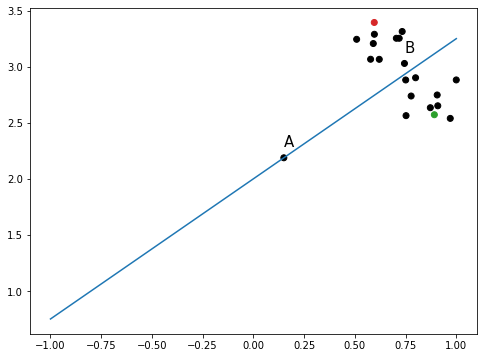

In [ ]:
# definindo uma região clara no espaco
x = np.linspace(-1, 1, 100)
a, b = 2, 1.25
col = []
n = []
for i in range(0, 21):
    col.append('black')
    n.append("")

col[5] = "tab:red"
col[18] = "tab:green"
n[1] = "B"
n[20] = "A"
np.random.seed(125)
# definindo pontos
p1 = np.concatenate([np.random.uniform(3, 3.5, 10), np.random.uniform(2.5, 2.95, 10), np.array([2.1875])])
p2 = np.concatenate([np.random.uniform(0.5, 0.75, 10),np.random.uniform(0.75, 1, 10), np.array([0.15])])
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(p2, p1, c = col)
for i, txt in enumerate(n):
    ax.annotate(txt, (p2[i], p1[i] + 0.1), size = 15)
plt.plot(x, a + b*x, color = "tab:blue")
plt.savefig(f"{images_dir}/metodos_ponderados_por_dens.pdf")
plt.show()

In [ ]:
coords = np.vstack((p1, p2)).T

Refazendo o gráfico acima porém com densidade de informação estimada:

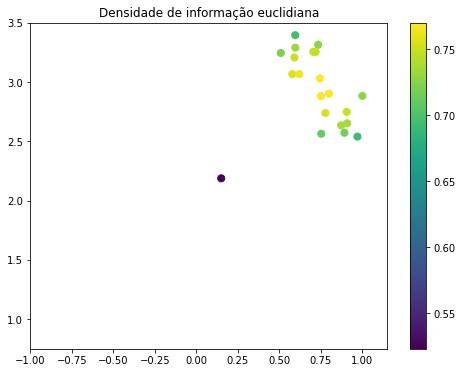

In [ ]:
from modAL.density import information_density
mapColS = [plt.cm.hot(i) for i in np.linspace(0.75, 0, 250)]
MyCmap = colors.ListedColormap(mapColS)

plt.figure(figsize=(8, 6))
euclidean_density = information_density(coords, 'euclidean')
plt.scatter(x= p2, y= p1, c = euclidean_density, cmap= "viridis", s=50)
plt.title('Densidade de informação euclidiana')
plt.colorbar()
plt.xlim(-1, 1.15)
plt.ylim(0.75, 3.5)
plt.savefig(f"{images_dir}/dens_euclidiana_dados_sim.pdf")
plt.show()

Comparando o desempenho de error reduction com QBC e uncertainty sampling em um banco de dados toy:

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t


# gerando dados com 3 labels:
# poucos dados sem muita interseção
n_1, n_2, n_3 = 100, 100, 100

mu_0 = [-3, -5.75]
mu_1 = [1, 0.65]
mu_2 = [4, -7.25]
# pegando distribuicao t multivariada com grau de liberdade muito baixo
rv_1 = multivariate_t(mu_0, [[1, 0.3], [0.3, 1]], df = 1.75)
rv_2 = multivariate_t(mu_1, [[1, 0], [0, 1]], df = 2.85)
rv_3 = multivariate_t(mu_2, [[1.5, 0.35], [0.35, 1.5]], df = 2.25)


seed = 1065
np.random.seed(seed)
classes = np.concatenate([np.zeros(n_1), np.ones(n_2), np.repeat(2, n_3)])

ImportError: ignored

In [ ]:
# dados do treinamento do modelo de aprendizado ativo
X = np.zeros((n_1 + n_2 + n_3, 2))

X[classes == 0, :] = rv_1.rvs(size = n_1)
X[classes == 1, :] = rv_2.rvs(size = n_2)
X[classes == 2, :] = rv_3.rvs(size = n_3)
# primeira mistura de duas normais mu_0 = [2, 0], mu_0 = [-2, 0]
# segunda eh uma normal mu_0 = [0, 0]

sim_data = pd.DataFrame(data = {'X1' : X[:, 0],
                                 'X2' : X[:, 1],
                                 'target': classes})

sns.set_palette("Set1")
plt.figure(figsize = (10,8))
sim_data['classes'] = pd.Categorical(sim_data.target)
sns.scatterplot(data = sim_data, x = "X1", y = "X2", hue = 'classes')
plt.show()

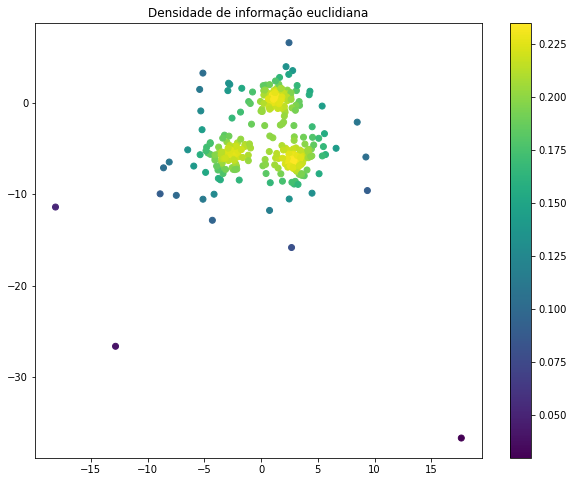

In [ ]:
plt.figure(figsize=(10, 8))
euclidean_density = information_density(X, 'euclidean')
plt.scatter(x= X[:, 0], y= X[:, 1], c = euclidean_density, cmap= "viridis")
plt.title('Densidade de informação euclidiana')
plt.colorbar()
plt.show()

Density information sendo declarado

In [ ]:
def density_custom_query_strategy(classifier, X, n_instances = 1, base_strategy = classifier_uncertainty, sim_type = "euclidean", beta = 1):
  density = information_density(X, sim_type)
  base_strategy_values = base_strategy(classifier, X)
  utility = np.multiply(base_strategy_values, density**beta)
  query_idx = multi_argmax(utility, n_instances = n_instances)
  return query_idx, X[query_idx]

array([[-2.74963676e+00, -2.63557674e+00],
       [-1.43080332e+11, -5.89252095e+09],
       [-1.22517386e+05, -1.14014490e+05],
       [-8.12241896e+13, -5.30890941e+13],
       [ 3.68836189e+05, -3.37239671e+06],
       [-3.45155177e+00,  2.59044981e-02],
       [-2.37278988e+00, -8.76801870e-01],
       [-5.18249284e+02, -1.16526934e+03],
       [-3.50520643e-01,  1.00353853e-02],
       [-3.25618372e+06, -4.97110599e+06],
       [ 2.98562634e+06,  3.47692716e+06],
       [ 9.36647986e+00, -1.24234042e+01],
       [-6.50658049e+02,  2.02383725e+01],
       [ 1.24112868e+01, -4.81547764e+00],
       [-1.01915896e+00,  1.73773916e-01],
       [-6.07509172e+09, -2.88467490e+11],
       [-4.20839614e+04, -6.22839526e+03],
       [-7.76943541e-01,  3.24783114e-01],
       [-2.13877470e+05, -1.49203207e+05],
       [ 2.55093941e+01,  4.28459462e+02],
       [-1.95138032e+00,  1.13380987e+00],
       [-1.63814905e+07, -3.61054743e+07],
       [-1.70074643e+07,  6.40973314e+06],
       [-6.

Exemplo de stream-based uncertainty sampling em um exemplo toy para classificação de imagens:

In [ ]:
import numpy as np

# criando a imagem
im_width = 500
im_height = 500
im = np.zeros((im_height, im_width))
im[100:im_width - 1 - 100, 100:im_height - 1 - 100] = 1

# criando os dados para consultar
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

In [ ]:
from modAL.uncertainty import classifier_uncertainty
import sklearn as skl
# assembling initial training set
np.random.seed(1250)

n_initial = 5
initial_idx = np.random.choice(range(len(X_full)), size=n_initial, replace=False)
X_train, y_train = X_full[initial_idx], y_full[initial_idx]
x1, x2 = np.meshgrid(np.arange(0, 500), np.arange(0, 500))
z = np.stack((x1.ravel(), x2.ravel()), axis=-1)


# initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=y_train
)

X_stream = np.delete(X_full, initial_idx, axis=0)
y_stream = np.delete(y_full, initial_idx)

n = 1
preds_list = []
regions = []

while n <= 30:
  stream_idx = np.random.choice(range(len(X_stream)))
  if classifier_uncertainty(learner, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
    learner.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
    X_stream = np.delete(X_stream, stream_idx, axis=0)
    y_stream = np.delete(y_stream, stream_idx)
    if n in [5, 10, 15]:
      preds_list.append(learner.predict(X_full))
      region = np.logical_and(np.reshape(classifier_uncertainty(learner, z), (500, 500)) >= 0.4, np.reshape(learner.predict(X_full) != 1, (500, 500)))
      region = region.astype("int")*0.5
      regions.append(region)
    n += 1
  else:
    X_stream = np.delete(X_stream, stream_idx, axis=0)
    y_stream = np.delete(y_stream, stream_idx)

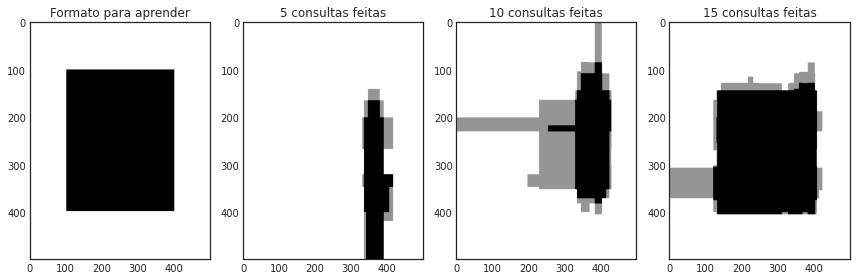

In [ ]:
from matplotlib import colors

# cor do mapa de calor
mapCols = [plt.cm.binary(i) for i in np.array([0, 0.99, 0.5])]
MyCmap = colors.ListedColormap(mapCols)


plt.figure(figsize = (12, 4))
with plt.style.context('seaborn-white'):
  plt.subplot(1, 4, 1)
  plt.imshow(im, aspect='auto')
  plt.title('Formato para aprender')


idx = [5, 10, 15]
for i in range(3):
  j = i + 2
  with plt.style.context('seaborn-white'):
    plt.subplot(1, 4, j)
    prediction = preds_list[i]
    all = regions[i] + prediction.reshape(500, 500)
    plt.imshow(all.reshape(im_width, im_height), cmap = "Greys", aspect='auto')
    plt.title("{} consultas feitas".format(idx[i]))

plt.tight_layout()
plt.savefig(f"{images_dir}/stream_based_uncertainty_sampling.pdf")

In [ ]:
learner.X_training

array([[ 51, 141],
       [115,  68],
       [325,  23],
       [342, 260],
       [ 20,  42],
       [315, 435],
       [465, 473],
       [364, 366],
       [413,  21],
       [465, 274],
       [393, 329],
       [373, 445],
       [454, 376],
       [392, 186],
       [392, 146],
       [308, 333],
       [150, 375],
       [ 92, 275],
       [169, 233],
       [423, 280],
       [ 75, 339],
       [412, 329],
       [329, 379],
       [115, 199],
       [ 29, 234],
       [161, 425],
       [190, 134],
       [375,  97],
       [387, 405],
       [103, 188],
       [105, 299],
       [300, 396],
       [ 92, 199],
       [403, 205],
       [258, 410]])

In [ ]:
x1, x2 = np.meshgrid(np.arange(0,500), np.arange(0,500))
z = np.stack((x1.ravel(), x2.ravel()), axis=-1)

a = np.reshape(consensus_entropy(comite_logis, z), (500, 500)) >= 0.4
a = a.astype("int")*0.5

In [ ]:
prediction.reshape(500, 500)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
classifier_list[0]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


array(ActiveLearner(X_training=array([[ 51, 141],
       [115,  68],
       [325,  23],
       [342, 260],
       [ 20,  42],
       [315, 435],
       [465, 473],
       [364, 366],
       [413,  21],
       [465, 274],
       [393, 329],
       [373, 445],
       [454, 376],
       [392, 186],
       [392, 146],
       [308, 333],
       [150, 375],
       [ 92, 275],
       [169, 233],
       [423, 280],
       [ 75, 339],
       [412, 329],
       [329, 379],
       [115, 199],
       [ 29, 234],
       [161, 425],
       [190, 134],
       [375,  97],
       [387, 405],
       [103, 188],
       [105, 299],
       [300, 396],
       [ 92, 199]...
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=100, n_jobs=None,
                                               oob

In [ ]:
learner.predict(X_full)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
a = 1
if a in [20, 30, 1]:
  print(a)

1
